### Here we train a federared time-series model with exogenous data. Our exogenous data are the datetime features and statistics describing the previous time steps such as mean and median for the targets of interest, i.e., up and down measurements.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

import pandas as pd

from matplotlib import pyplot as plt

from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [7]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    # here we define the exogenous data
    assign_stats=["mean", "median", "std", "variance", "kurtosis", "skew"],
    use_time_features=True # whether to use datetime features
)

In [8]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(aggregation='fedavg', assign_stats=['mean', 'median', 'std', 'variance', 'kurtosis', 'skew'], batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', epochs=3, fl_rounds=30, fraction=1.0, identifier='District', local_early_stopping=False, local_patience=50, lr=0.001, max_grad_norm=0.0, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=True, reg1=0.0, reg2=0.0, seed=0, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], test_size=0.2, use_time_features=True, x_scaler='minmax', y_scaler='minmax')



In [9]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [10]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [11]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
seed_all()

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [14]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers = make_preprocessing()

INFO logger 2024-05-18 22:03:14,069 | data_utils.py:383 | Observations info in ElBorn
INFO logger 2024-05-18 22:03:14,069 | data_utils.py:384 | 	Total number of samples:  4192
INFO logger 2024-05-18 22:03:14,069 | data_utils.py:385 | 	Number of samples for training: 3354
INFO logger 2024-05-18 22:03:14,070 | data_utils.py:386 | 	Number of samples for validation:  838
INFO logger 2024-05-18 22:03:14,072 | data_utils.py:383 | Observations info in LesCorts
INFO logger 2024-05-18 22:03:14,073 | data_utils.py:384 | 	Total number of samples:  6892
INFO logger 2024-05-18 22:03:14,073 | data_utils.py:385 | 	Number of samples for training: 5514
INFO logger 2024-05-18 22:03:14,073 | data_utils.py:386 | 	Number of samples for validation:  1378
INFO logger 2024-05-18 22:03:14,076 | data_utils.py:383 | Observations info in PobleSec
INFO logger 2024-05-18 22:03:14,076 | data_utils.py:384 | 	Total number of samples:  15927
INFO logger 2024-05-18 22:03:14,076 | data_utils.py:385 | 	Number of samples f

In [15]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [16]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [17]:
exogenous_data_train.keys()

dict_keys(['ElBorn', 'LesCorts', 'PobleSec', 'all'])

In [18]:
exogenous_data_train["ElBorn"]

array([[-8.66025404e-01, -5.00000000e-01,  9.94521895e-01, ...,
         1.55299715e-04, -1.39554441e+00,  3.54587851e-01],
       [-8.66025404e-01, -5.00000000e-01,  9.51056516e-01, ...,
         1.29676679e-04, -1.11451559e+00,  1.87895259e-01],
       [-8.66025404e-01, -5.00000000e-01,  8.66025404e-01, ...,
         1.33929690e-04, -7.58042771e-01,  6.37791527e-01],
       ...,
       [ 9.65925826e-01, -2.58819045e-01, -7.43144825e-01, ...,
         3.48186172e-08,  3.77765403e+00,  2.12681094e+00],
       [ 9.65925826e-01, -2.58819045e-01, -8.66025404e-01, ...,
         3.48186172e-08,  3.77765403e+00,  2.12681094e+00],
       [ 9.65925826e-01, -2.58819045e-01, -9.51056516e-01, ...,
         3.48186172e-08,  3.77765403e+00,  2.12681094e+00]])

In [19]:
# 4 datetime features + 5 (targets) * 6 (stats) = 4 + 30 = 34 
len(exogenous_data_train["ElBorn"][0])

34

In [20]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [21]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [22]:
# define the model
args.model_name = "rnn"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

11 34


In [23]:
model

RNN(
  (rnn): RNN(11, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=162, out_features=5, bias=True)
  )
)

In [24]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[8, 3, 1, 10, 9], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=False
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [25]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

In [26]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params,
    exogenous_data_train=exogenous_data_train,
    exogenous_data_val=exogenous_data_val
)

INFO logger 2024-05-18 22:03:15,971 | server.py:62 | Initializing client manager...
INFO logger 2024-05-18 22:03:15,973 | server.py:69 | Registering clients...
INFO logger 2024-05-18 22:03:15,974 | client_manager.py:66 | Registered client with id: ElBorn
INFO logger 2024-05-18 22:03:15,975 | client_manager.py:66 | Registered client with id: LesCorts
INFO logger 2024-05-18 22:03:15,975 | client_manager.py:66 | Registered client with id: PobleSec
INFO logger 2024-05-18 22:03:15,976 | server.py:73 | Client manager initialized!
INFO logger 2024-05-18 22:03:15,977 | server.py:55 | Aggregation algorithm: FedAvg()
INFO logger 2024-05-18 22:03:15,977 | client_manager.py:88 | Parameter c=0.0. Sampled 1 client(s): ['LesCorts']
INFO logger 2024-05-18 22:03:16,671 | server.py:86 | Starting FL rounds
INFO logger 2024-05-18 22:03:16,672 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['LesCorts', 'ElBorn', 'PobleSec']
INFO logger 2024-05-18 22:03:18,328 | train_utils.py:142 | Best Los

In [27]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [28]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [29]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scaler used to transform the targets
    idxs=[8, 3, 1, 10, 9],
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on ElBorn
Prediction on LesCorts
Prediction on PobleSec


INFO logger 2024-05-18 22:05:51,514 | helpers.py:60 | Metrics for dimension: 0
	mse: 874488.625, rmse: 935.1409653095088, mae: 614.2802124023438, r^2: 0.8506979805554507, nrmse: 0.22785042205172643
INFO logger 2024-05-18 22:05:51,515 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00015327146684285253, rmse: 0.012380285410395535, mae: 0.006622803397476673, r^2: 0.9266966099024143, nrmse: 0.29844056199245306
INFO logger 2024-05-18 22:05:51,516 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.741763662721496e-05, rmse: 0.0041734442163775184, mae: 0.0018974806880578399, r^2: 0.9254621438276464, nrmse: 0.4862556338721056
INFO logger 2024-05-18 22:05:51,518 | helpers.py:60 | Metrics for dimension: 3
	mse: 1406169474138112.0, rmse: 37498926.30647059, mae: 20910350.0, r^2: 0.888091260617114, nrmse: 0.25546505335891656
INFO logger 2024-05-18 22:05:51,520 | helpers.py:60 | Metrics for dimension: 4
	mse: 27265570177024.0, rmse: 5221644.393964798, mae: 2563029.5, r^2: 0.927371990459471, nrms


Final Prediction on ElBorn (Inference Stage)
[Train]: mse: 286687154405376.0, rmse: 16931838.48273353, mae 4694798.5, r2: 0.9036639970724192, nrmse: 0.3437949797654225
[Val]: mse: 38074440482816.0, rmse: 6170448.969306529, mae 2139327.0, r2: 0.7699056098016543, nrmse: 0.39316920227349555




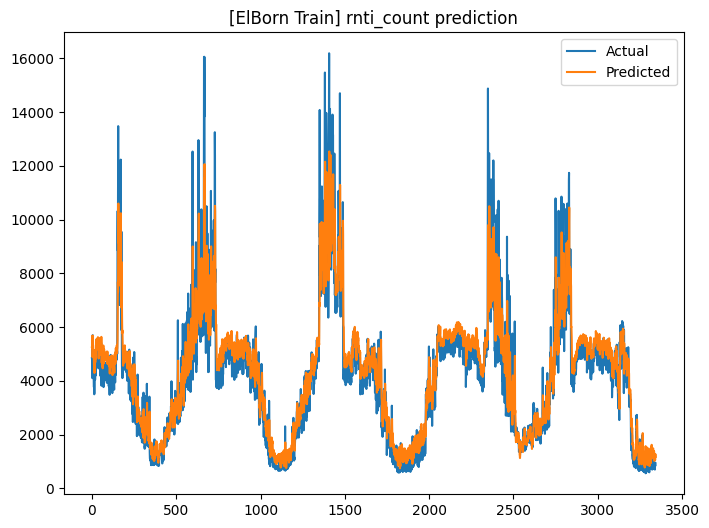

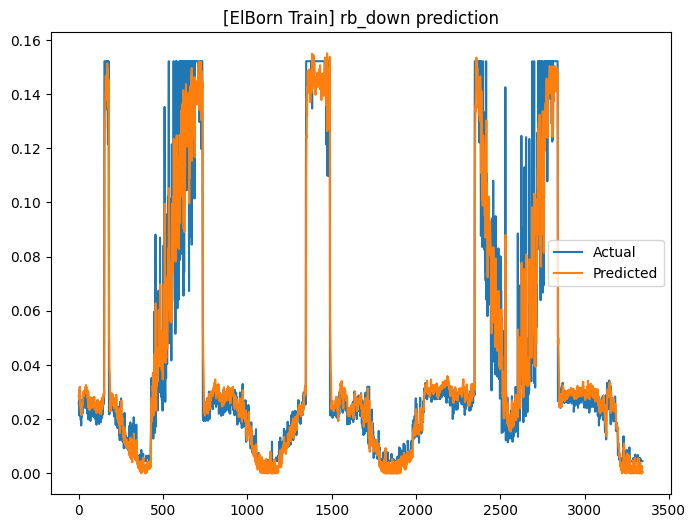

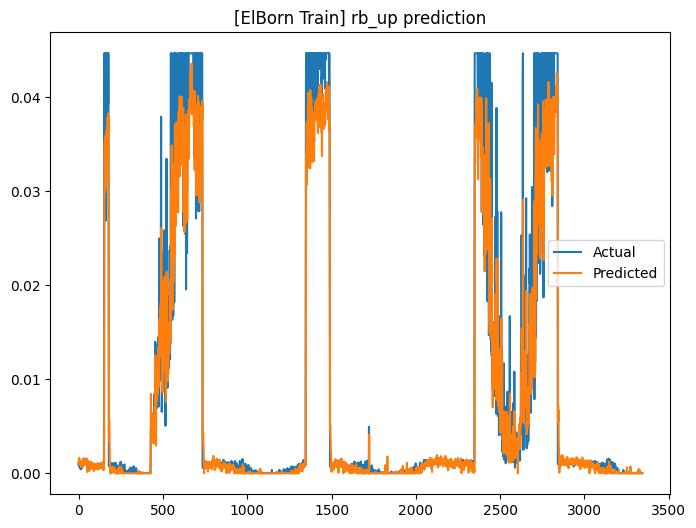

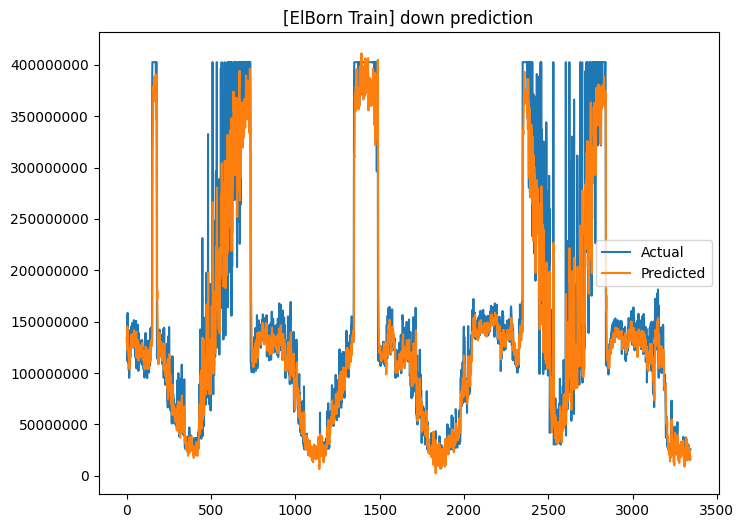

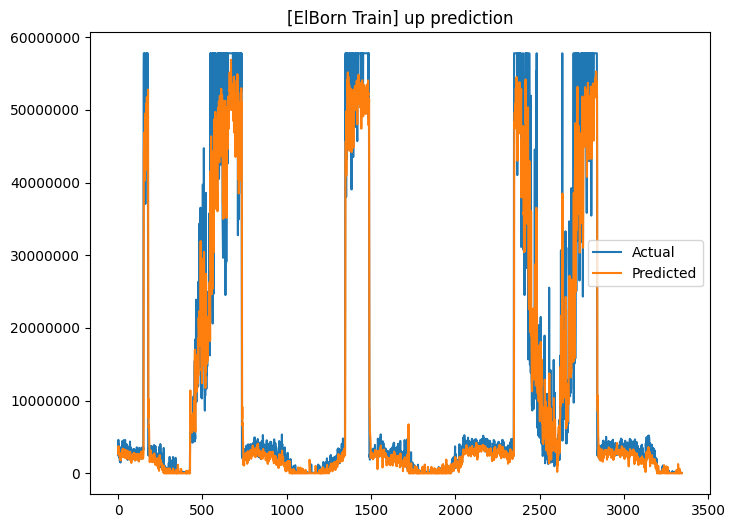

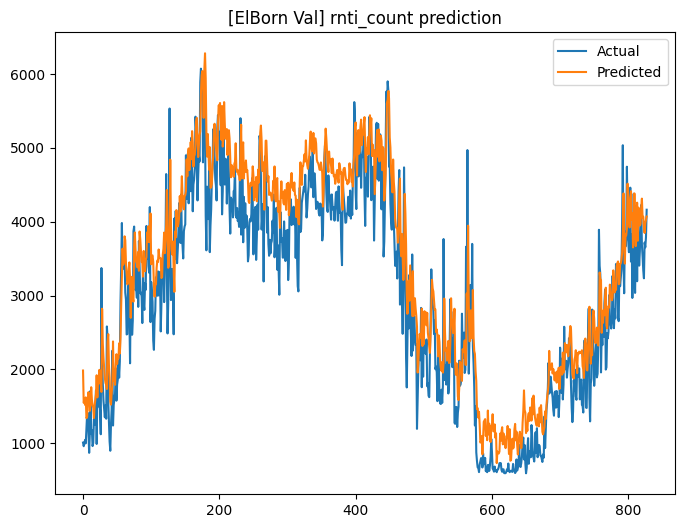

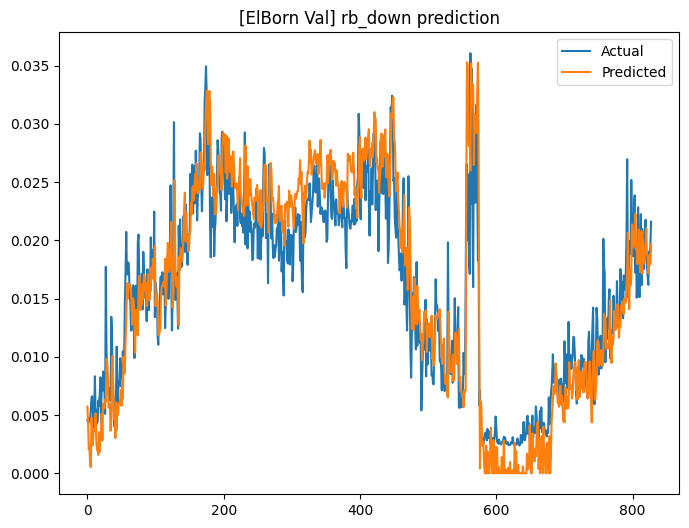

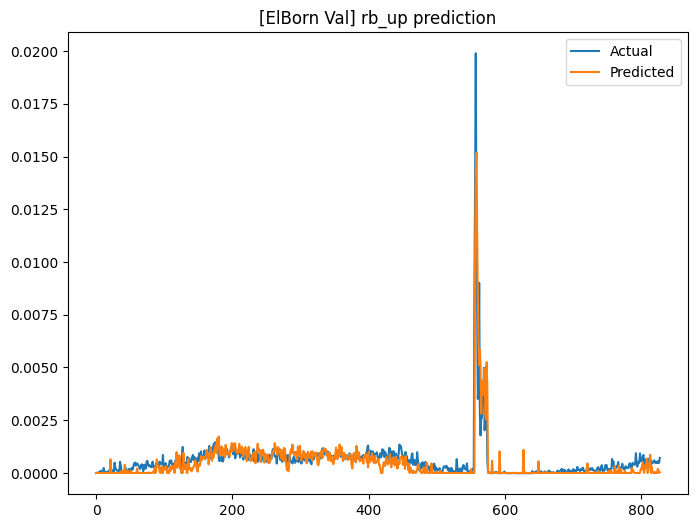

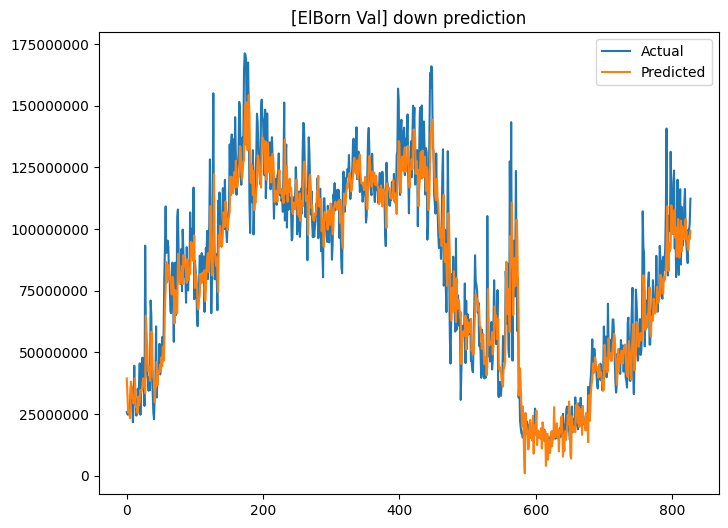

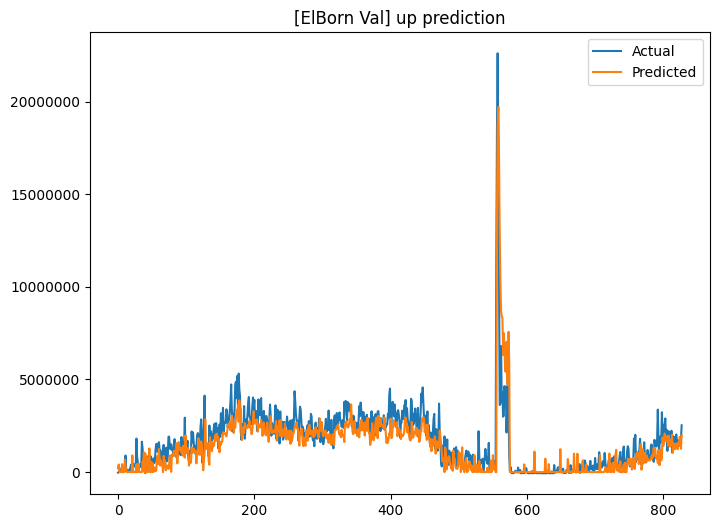

INFO logger 2024-05-18 22:05:53,022 | helpers.py:60 | Metrics for dimension: 0
	mse: 614554.9375, rmse: 783.9355442254165, mae: 580.3145141601562, r^2: 0.8682150408130471, nrmse: 0.18470635883120773
INFO logger 2024-05-18 22:05:53,023 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0005506938323378563, rmse: 0.023466866691952214, mae: 0.016631389036774635, r^2: 0.7546609815742248, nrmse: 0.3072907682190058
INFO logger 2024-05-18 22:05:53,025 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.8925140213686973e-05, rmse: 0.005378209759175164, mae: 0.0032488612923771143, r^2: 0.8802088466085447, nrmse: 0.507702453534354
INFO logger 2024-05-18 22:05:53,027 | helpers.py:60 | Metrics for dimension: 3
	mse: 2719694624653312.0, rmse: 52150691.50695235, mae: 39774552.0, r^2: 0.8329283982329524, nrmse: 0.2777186925928851
INFO logger 2024-05-18 22:05:53,029 | helpers.py:60 | Metrics for dimension: 4
	mse: 46896840179712.0, rmse: 6848126.7642846685, mae: 4074095.75, r^2: 0.882219237129006, nrms


Final Prediction on LesCorts (Inference Stage)
[Train]: mse: 553317683953664.0, rmse: 23522705.710731152, mae 8769845.0, r2: 0.8436465008715549, nrmse: 0.37762091229106093
[Val]: mse: 1037803148279808.0, rmse: 32214952.247051492, mae 11027520.0, r2: -3.1357122148268273, nrmse: 0.8962913542575658




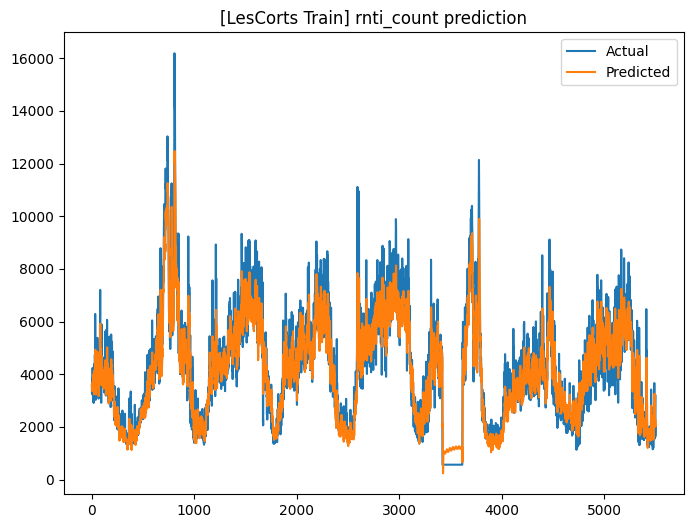

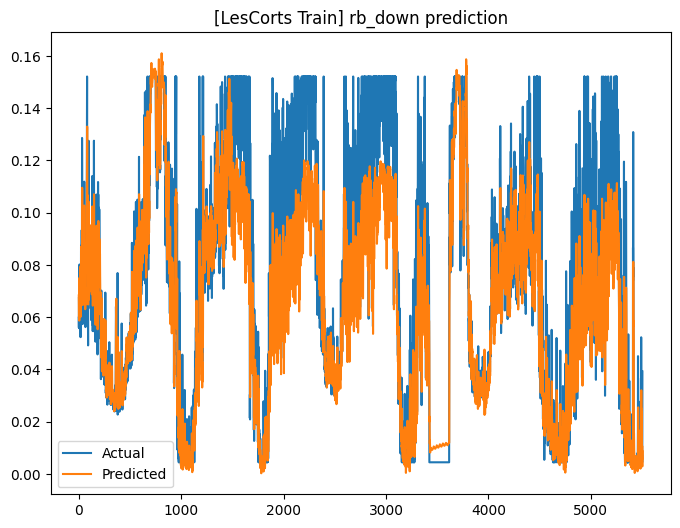

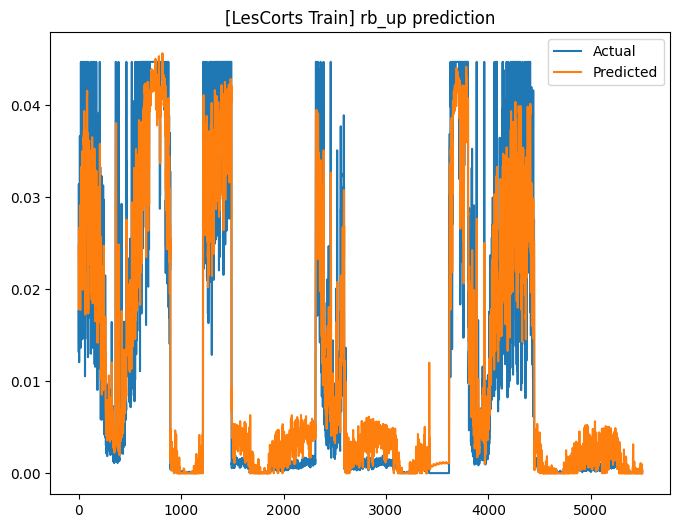

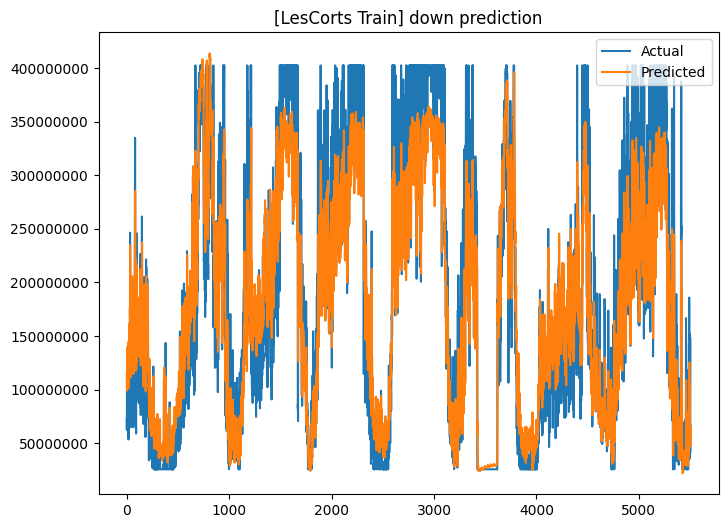

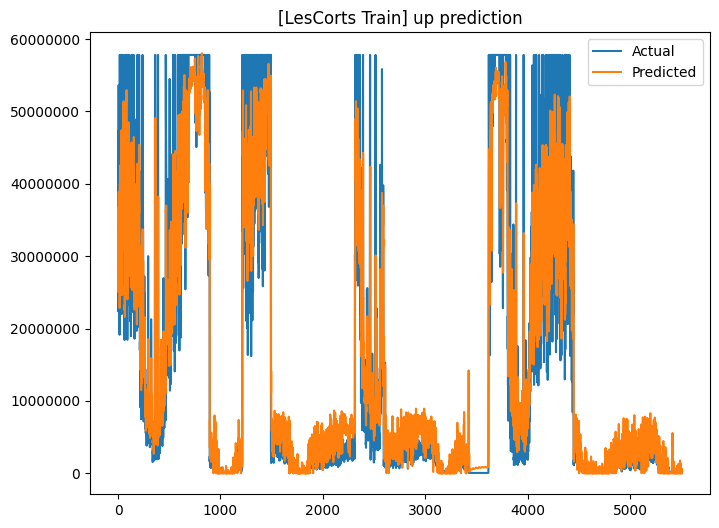

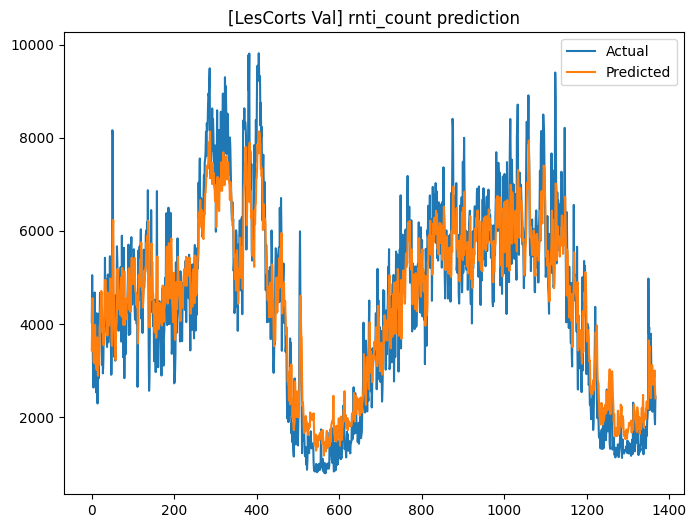

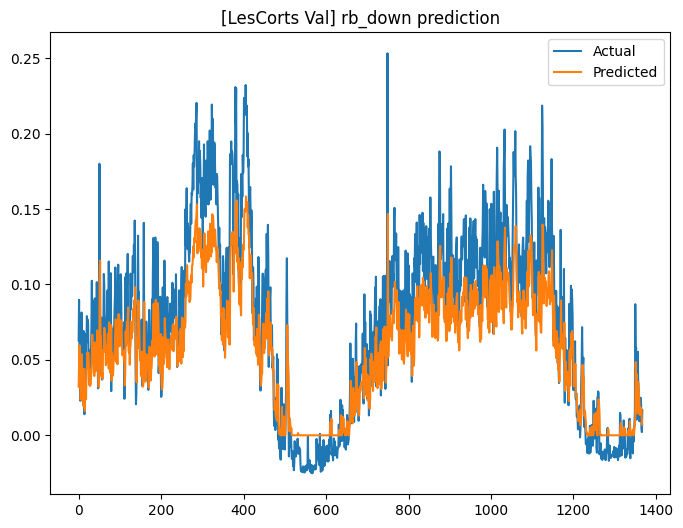

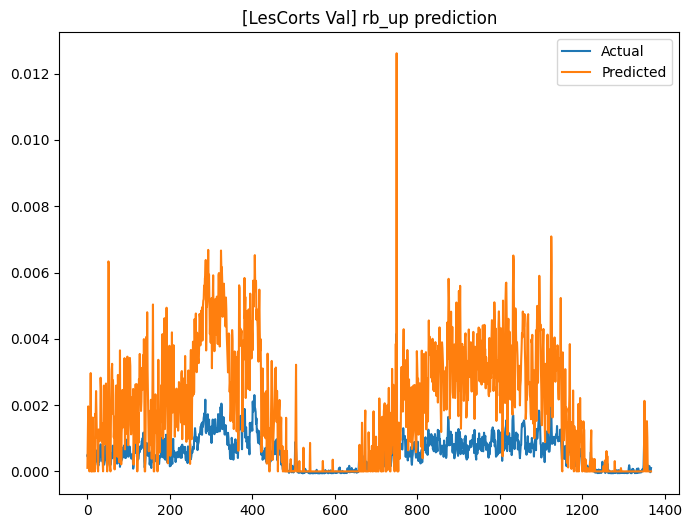

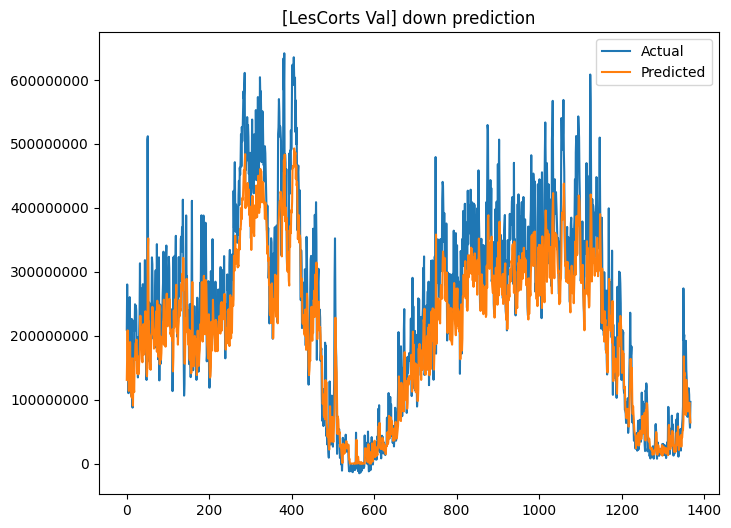

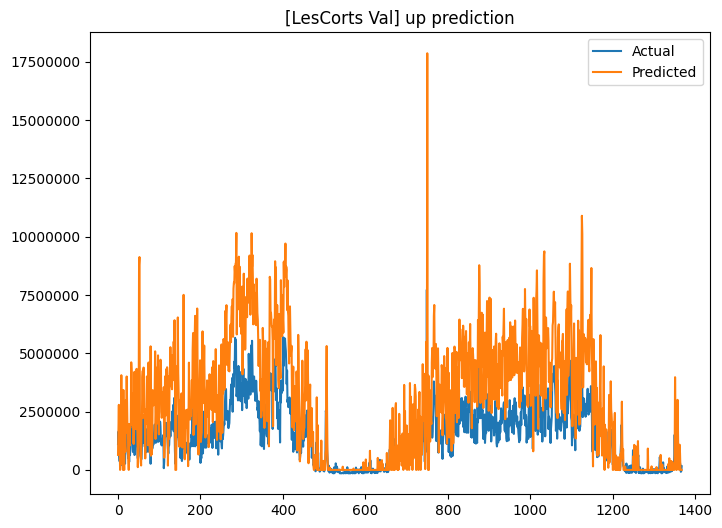

INFO logger 2024-05-18 22:05:54,538 | helpers.py:60 | Metrics for dimension: 0
	mse: 1368771.0, rmse: 1169.9448704960419, mae: 820.5988159179688, r^2: 0.7692995214028626, nrmse: 0.2142565524040475
INFO logger 2024-05-18 22:05:54,541 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00027203757781535387, rmse: 0.016493561707992422, mae: 0.009639429859817028, r^2: 0.8367474170279177, nrmse: 0.47659318051729244
INFO logger 2024-05-18 22:05:54,543 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.3411354050040245e-05, rmse: 0.004838528087139749, mae: 0.00200454774312675, r^2: 0.882325846392188, nrmse: 0.6448874440334279
INFO logger 2024-05-18 22:05:54,545 | helpers.py:60 | Metrics for dimension: 3
	mse: 2164920409915392.0, rmse: 46528705.22500483, mae: 30160514.0, r^2: 0.776277495578503, nrmse: 0.36286016277086225
INFO logger 2024-05-18 22:05:54,547 | helpers.py:60 | Metrics for dimension: 4
	mse: 37884136521728.0, rmse: 6155009.059435087, mae: 2687140.25, r^2: 0.8801542110637944, nrmse:


Final Prediction on PobleSec (Inference Stage)
[Train]: mse: 440559323840512.0, rmse: 20989505.08803178, mae 6569702.0, r2: 0.8289608982930531, nrmse: 0.4932260559475313
[Val]: mse: 868473391546368.0, rmse: 29469872.608248036, mae 8101909.0, r2: 0.6037415129082604, nrmse: 1.2168576138441527




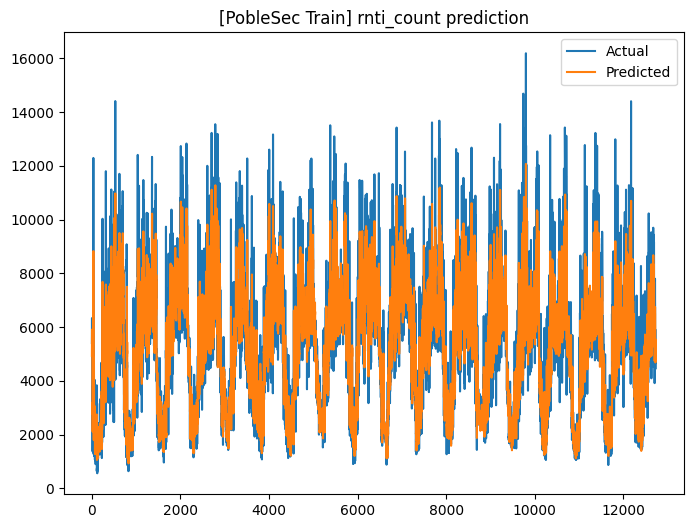

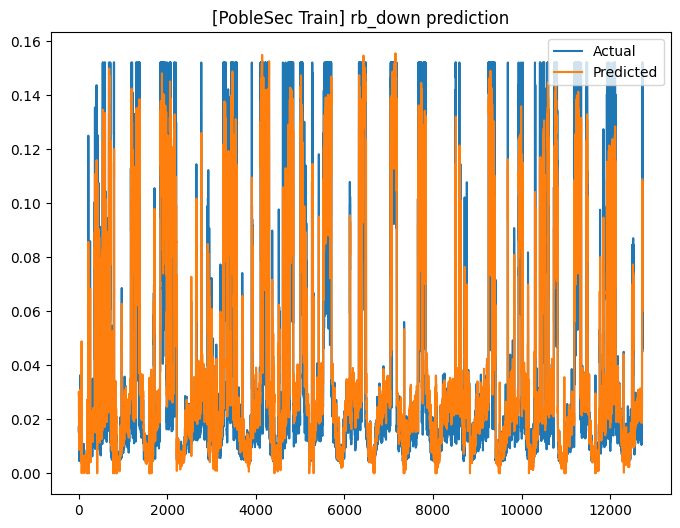

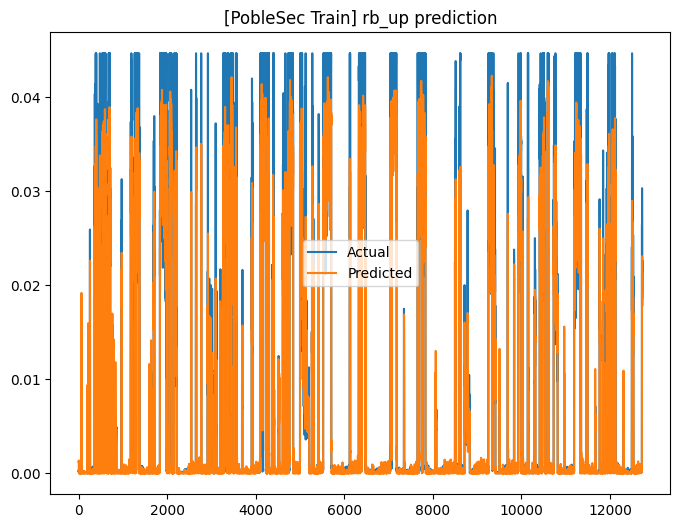

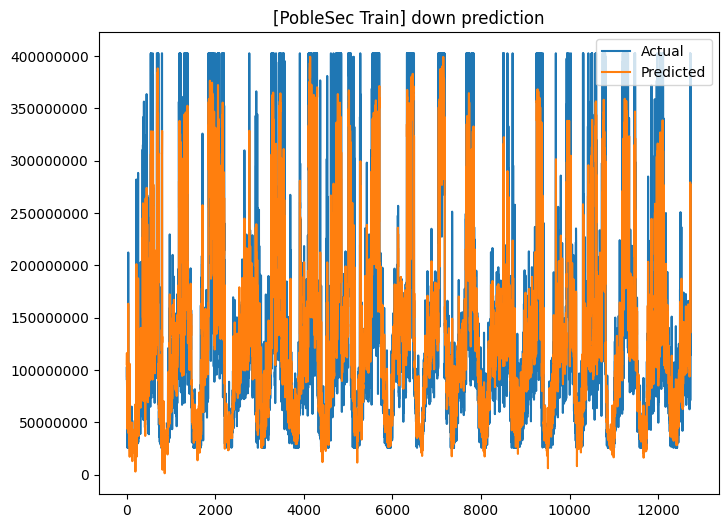

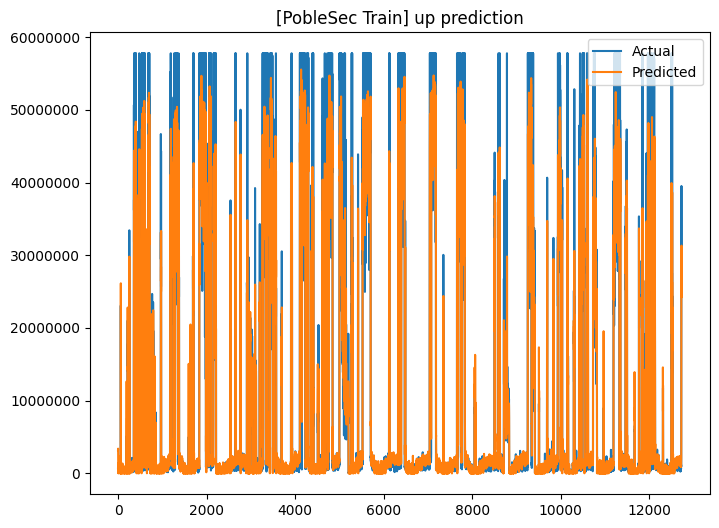

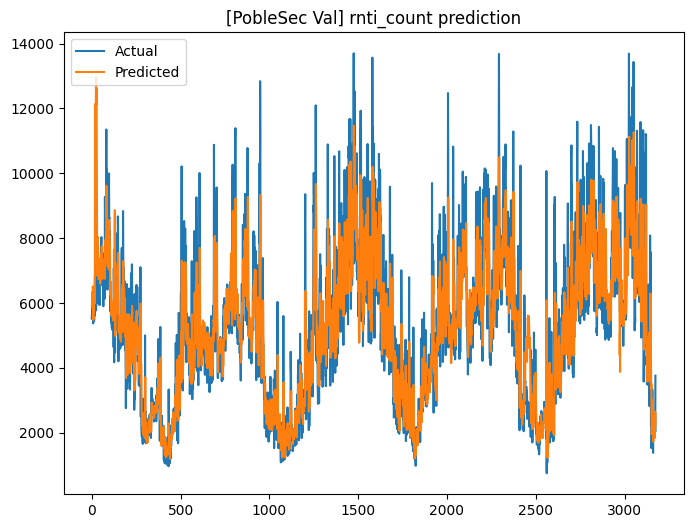

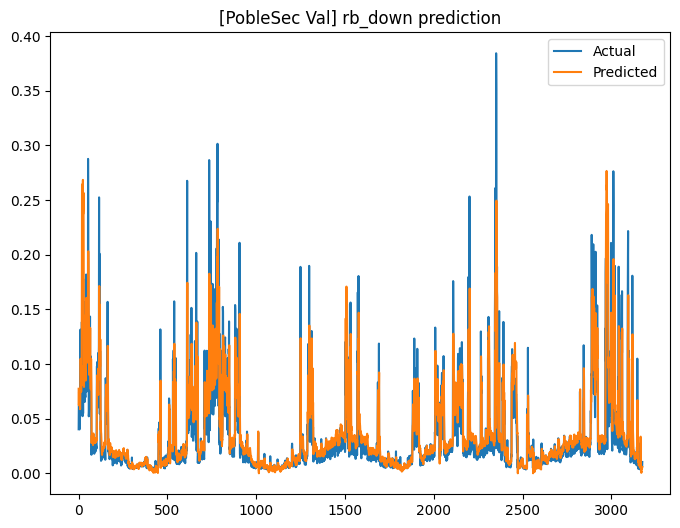

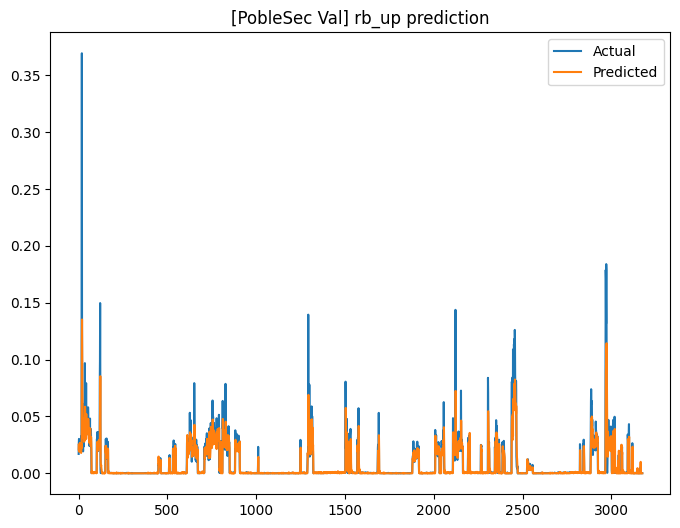

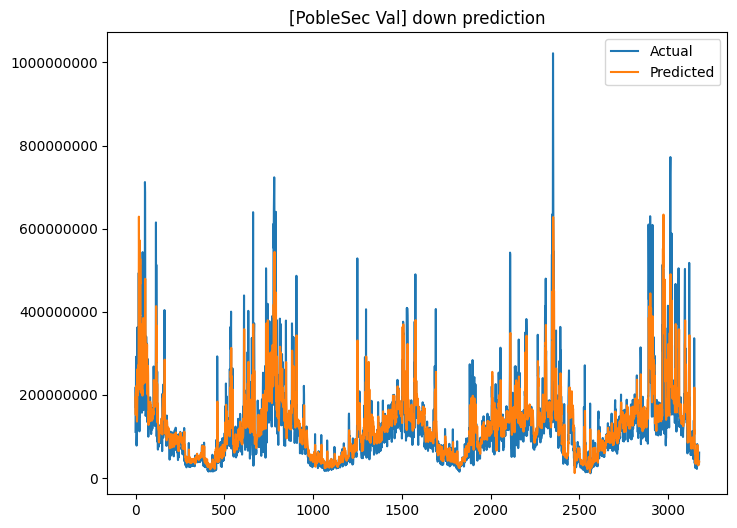

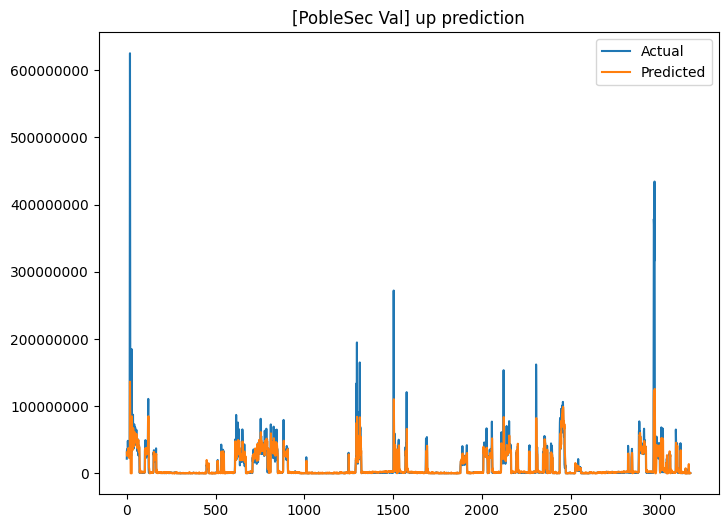

In [30]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers
)